# SOLO models: debugging
This notebook is to examine operation of models based upon a single data file, in order to evaluate how well the models work etc.

In [1]:
# file handling
from glob import glob
import os

# data + modelling
import math
import numpy as np
import pandas as pd
import pymc3 as pm

# plotting
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

# set up plotting preferences
plt.style.use('seaborn-darkgrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline
# %matplotlib notebook

In [2]:
# autoreload imported modules. Convenient while I'm developing the code.
%load_ext autoreload
%autoreload 2

## Import the models and other stuff we need

In [3]:
from models_solo import *
from df_data import *

## Import data

In [4]:
def import_files(files):
    """Import raw discounting data from a list of filenames.
    The user can adapt this function and the related functions in to come up 
    with the appropriately structured dataframe.
    """
    data = []
    for i,fname in enumerate(files):
        df = _import_person(fname)
        df = _new_col_of_value(df, 'id', i)
        initials, condition = _parse_filename(fname)
        df = _new_col_of_value(df, 'initials', initials)
        df = _new_col_of_value(df, 'condition', condition)
        data.append(df)

    return(pd.concat(data))

def _import_person(filename):
    return pd.read_csv(filename, sep='\t')

def _new_col_of_value(df, colname, value):
    df[colname] = pd.Series(value, index=df.index)
    return df

def _parse_filename(fname):
    path, file = os.path.split(fname)
    initials = file.split('-')[0]
    condition = file.split('-')[1]
    parent_foldername = path.split(os.sep)[-1]
    return (initials, condition)

def _generate_trial_col(df):
    df = df.reset_index()
    df['trial'] = df.index
    return df

In [5]:
files = glob('data/kirby/*.txt')
files

['data/kirby/AC-kirby27.txt',
 'data/kirby/BL-kirby27.txt',
 'data/kirby/bv-kirby27.txt',
 'data/kirby/CS-kirby27.txt',
 'data/kirby/EP-kirby27.txt',
 'data/kirby/JR-kirby27.txt',
 'data/kirby/KA-kirby27.txt',
 'data/kirby/LJ-kirby27.txt',
 'data/kirby/LY-kirby27.txt',
 'data/kirby/NA-kirby27.txt',
 'data/kirby/rm-kirby27.txt',
 'data/kirby/SB-kirby27.txt',
 'data/kirby/SK-kirby27.txt',
 'data/kirby/VD-kirby27.txt',
 'data/kirby/vs-kirby27.txt']

In [6]:
expt = 1
alldata = import_files(files)
alldata.head()

,A,DA,B,DB,R,id,initials,condition
0,80,0,85,157,0,0,AC,kirby27.txt
1,34,0,50,30,1,0,AC,kirby27.txt
2,25,0,60,14,1,0,AC,kirby27.txt
3,11,0,30,7,1,0,AC,kirby27.txt
4,49,0,60,89,0,0,AC,kirby27.txt


In [7]:
# extract list of unique participant names
participant_list = list(alldata.initials.unique())
print(participant_list)

['AC', 'BL', 'bv', 'CS', 'EP', 'JR', 'KA', 'LJ', 'LY', 'NA', 'rm', 'SB', 'SK', 'VD', 'vs']


# Select one data file to examine

In [8]:
#data = get_data_df_for_a_person(alldata, 'AH', 'gain')

data = alldata[alldata['initials'] == 'AC']
data

,A,DA,B,DB,R,id,initials,condition
0,80,0,85,157,0,0,AC,kirby27.txt
1,34,0,50,30,1,0,AC,kirby27.txt
2,25,0,60,14,1,0,AC,kirby27.txt
3,11,0,30,7,1,0,AC,kirby27.txt
4,49,0,60,89,0,0,AC,kirby27.txt
5,41,0,75,20,1,0,AC,kirby27.txt
6,34,0,35,186,0,0,AC,kirby27.txt
7,31,0,85,7,1,0,AC,kirby27.txt
8,19,0,25,53,0,0,AC,kirby27.txt
9,22,0,25,136,0,0,AC,kirby27.txt


# Parameter estimation: inspect results from multiple models

Define a handy function to plot diagnostic info for model fits.

In [9]:
def plot_stuff(model):
    
    print("median AUC: ", np.median(model.metrics['auc']))
    print("median log loss: ", np.median(model.metrics['log_loss']))

    # diagnostic plots
    pm.traceplot(model.trace, varnames=model.df_params);
    pm.autocorrplot(model.trace, varnames=model.df_params);

    # plot discount function + data
    model.plot(data)

    # pairplot
    trace_df = pm.trace_to_dataframe(model.trace, varnames=model.df_params)
    sns.pairplot(trace_df);

## Coinflip model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


sampling from model:  Coinflip


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_logodds__]
100%|██████████| 3000/3000 [00:01<00:00, 1715.46it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '49929' (I am process '49930')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/btvincent/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '49929' (I am process '49931')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/btvincent/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '49930' (I am process '49931')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/btvincent/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir


Calculating AUC metric
Calculating Log Loss metric
median AUC:  0.5
median log loss:  0.682938225451


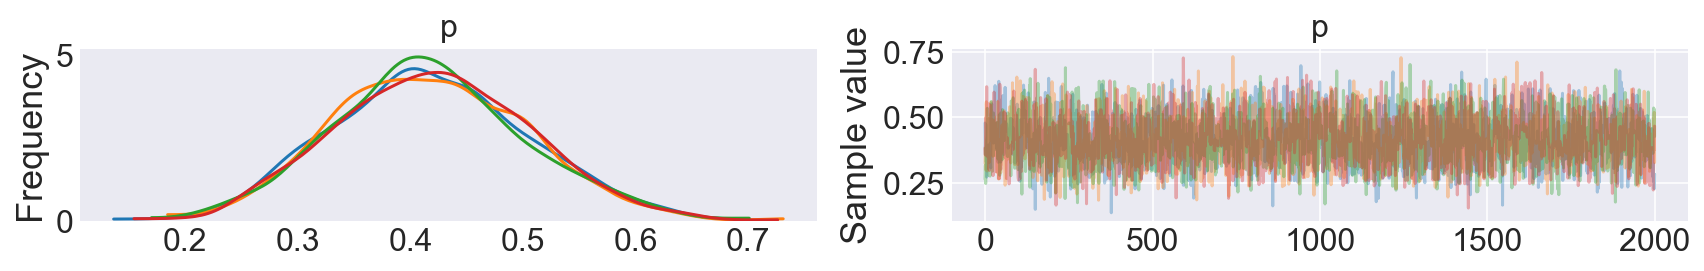

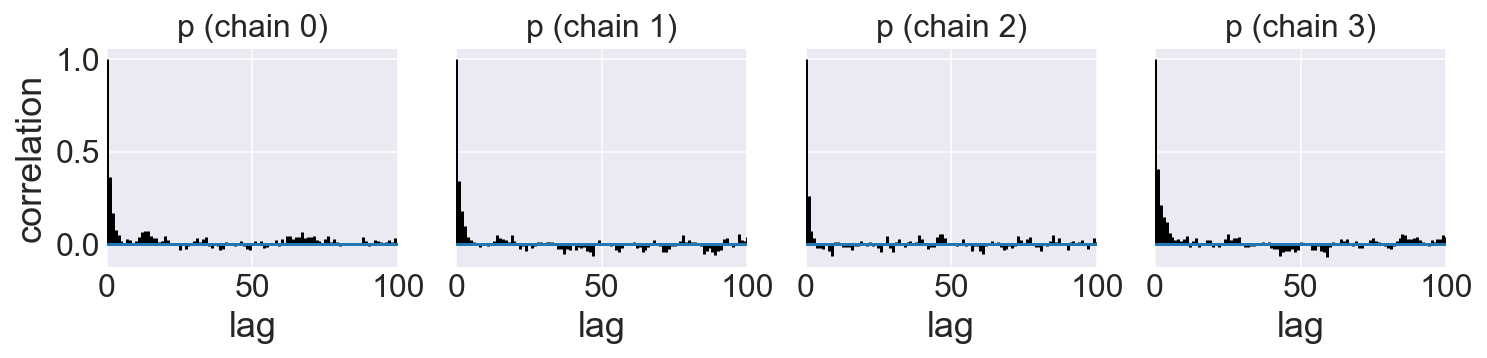

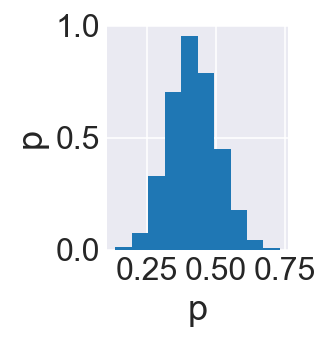

In [10]:
c = Coinflip()
c.sample_posterior(data, nsamples=2000)

plot_stuff(c)

## Exponential

In [ ]:
e = Exponential()
e.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(e)

In [ ]:
# fig, ax = e.plot(data)

# plt.savefig('temp_plots/temp.pdf', format='pdf')

## Hyperbolic model

In [ ]:
h = Hyperbolic()
h.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(h)

## Hyperbolic with magnitude effect

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


sampling from model:  HyperbolicMagnitudeEffect


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha_log__, c, m]
100%|██████████| 4000/4000 [01:14<00:00, 53.47it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.880543874978, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893384798496, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Calculating AUC metric
Calculating Log Loss metric
median AUC:  1.0
median log loss:  0.023670289097


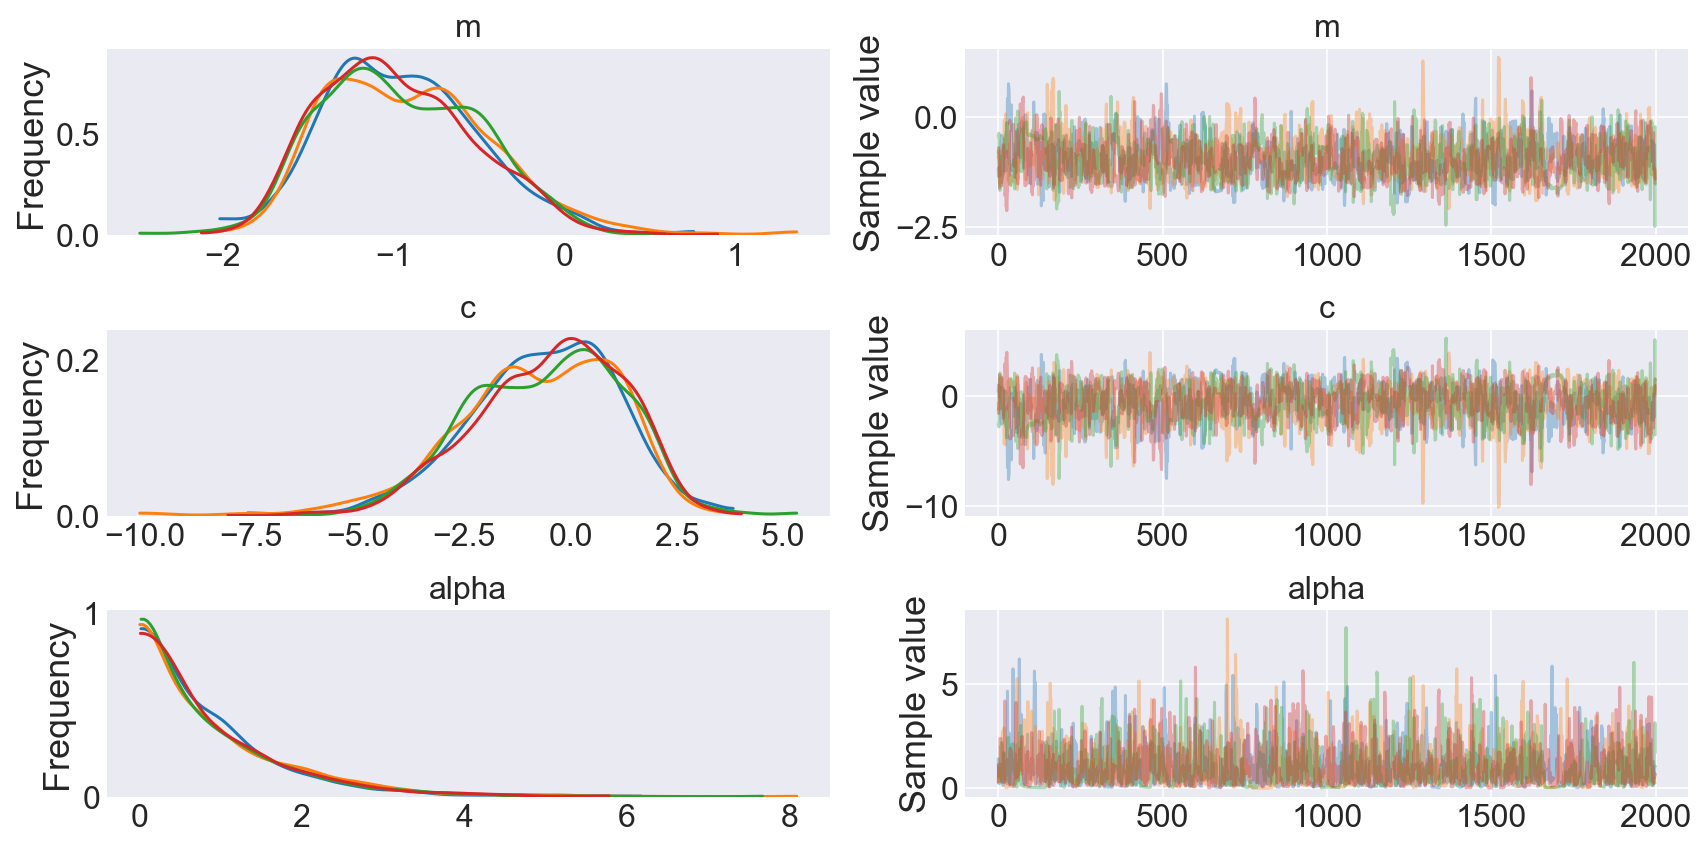

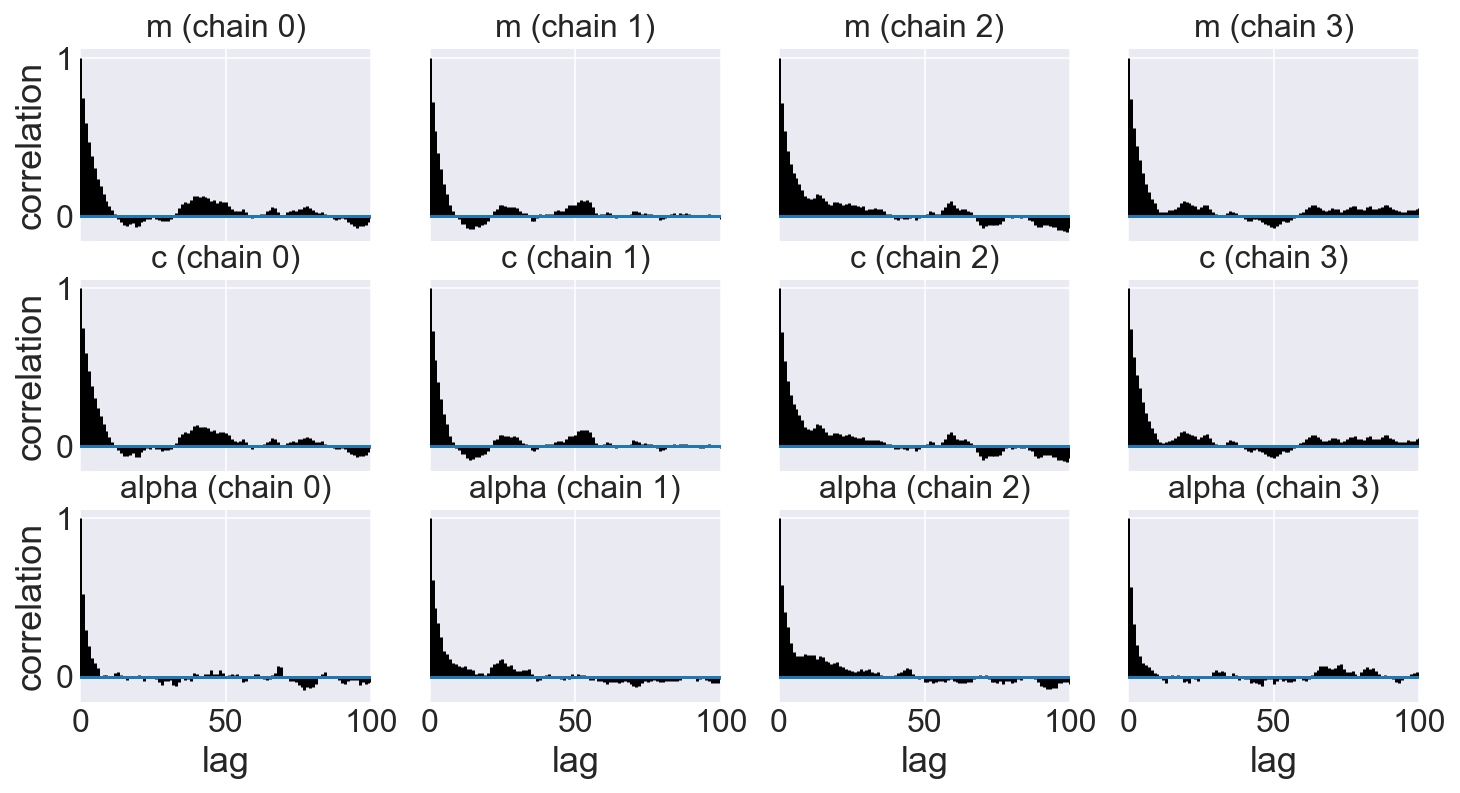

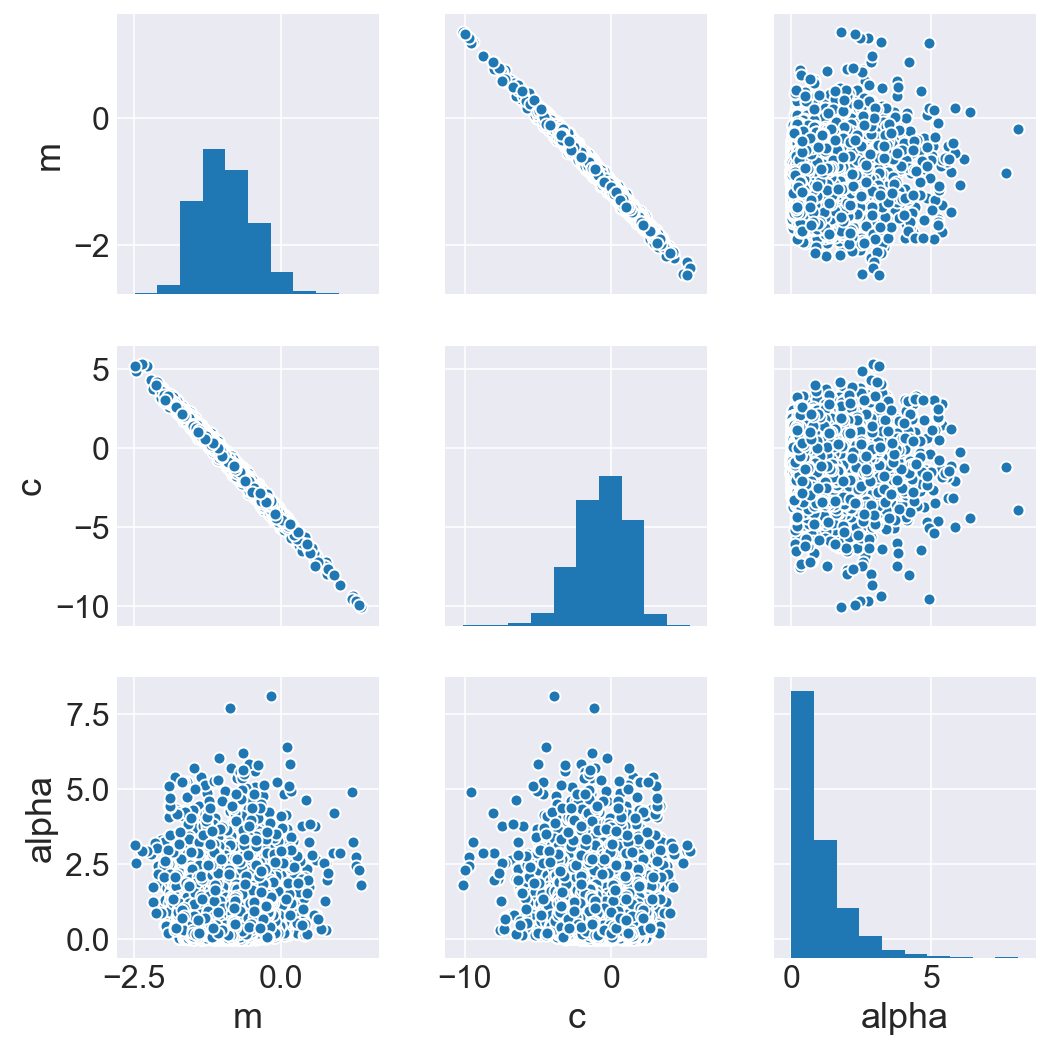

In [34]:
hma = HyperbolicMagnitudeEffect()
hma.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(hma)

## HyperboloidA

In [ ]:
ha = HyperboloidA()
ha.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(ha)

## HyperboloidB

In [ ]:
hb = HyperboloidB()
hb.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(hb)

## BetaDelta

In [ ]:
bd = BetaDelta()
bd.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(bd)

## DoubleExponential

In [ ]:
data = get_data_df_for_id_num(alldata, 0)

de = DoubleExponential()
de.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(de)

## ConstantSensitivity

In [ ]:
cs = ConstantSensitivity()
cs.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(cs)

## Exponential Power

In [ ]:
ep = ExponentialPower()
ep.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

plot_stuff(ep)

# Below are Heuristic models
As in models not based upon discounted utility. These are in-progress.

# EXPERIMENTAL: Trade-off model by Scholten & Read (2010)

In [ ]:
# def plot_stuff_nodf(model):
#     # diagnostic plots
#     pm.traceplot(model.trace, varnames=model.df_params);
#     pm.autocorrplot(model.trace, varnames=model.df_params);

#     # pairplot
#     trace_df = pm.trace_to_dataframe(model.trace, varnames=model.df_params)
#     sns.pairplot(trace_df);

def inspect_model(model):
    
    print("median AUC: ", np.median(model.metrics['auc']))
    print("median log loss: ", np.median(model.metrics['log_loss']))

    # diagnostic plots
    pm.traceplot(model.trace, varnames=model.df_params);
    pm.autocorrplot(model.trace, varnames=model.df_params);

    # pairplot
    trace_df = pm.trace_to_dataframe(model.trace, varnames=model.df_params)
    sns.pairplot(trace_df);

In [ ]:
to = TradeOff()
to.sample_posterior(data, nsamples=2000, target_accept=.95, tune=1000)

In [ ]:
# print("median AUC: ", np.median(to.metrics['auc']))
# print("median log loss: ", np.median(to.metrics['log_loss']))
# plot_stuff_nodf(to)
inspect_model(to)

# Experimental: ITCH model

In [ ]:
itch = ITCH()
itch.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

In [ ]:
# print("median AUC: ", np.median(itch.metrics['auc']))
# print("median log loss: ", np.median(itch.metrics['log_loss']))
# plot_stuff_nodf(itch)

inspect_model(itch)

# DRIFT model, Read et al (2013)

**WARNING:** This model breaks when `reward A > reward B`

In [ ]:
drift = DRIFT()
drift.sample_posterior(data, nsamples=2000, target_accept=.95, tune=2000)

In [ ]:
# print("median AUC: ", np.median(drift.metrics['auc']))
# print("median log loss: ", np.median(drift.metrics['log_loss']))
# plot_stuff_nodf(drift)

inspect_model(drift)

In [ ]:
# for file_index in range(0,len(files)):
#     data = get_data_df_for_id_num(alldata, file_index)
   
#     model = DoubleExponential()
#     model.sample_posterior(data)
        
#     # TODO: extract log loss into a dataframe. Row = participant, col = model
    
#     # plot discount function + data
#     #model.plot(data)

#     # pairplot
#     trace_df = pm.trace_to_dataframe(model.trace, varnames=model.df_params)
#     sns.pairplot(trace_df);
    
#     plt.savefig(f'temp_plots/double_exp/id{file_index}.pdf', format='pdf', bbox_inches='tight')